In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestClassifier



import tqdm

In [2]:
import sys
sys.path.append("/Users/elew/AssuredAutonomy/csaf_architecture/src")
import csaf.config as cconf
import csaf.system as csys

# create a csaf configuration out of toml
my_conf = cconf.SystemConfig.from_toml("/Users/elew/AssuredAutonomy/csaf_architecture/examples/f16/f16_shield_config.toml")

01:10:10 PM: (INFO)  setting up CSAF System from TOML file '/Users/elew/AssuredAutonomy/csaf_architecture/examples/f16/f16_shield_config.toml'
01:10:10 PM: (INFO)  Output Dir: /Users/elew/AssuredAutonomy/csaf_architecture/examples/f16/output
01:10:10 PM: (INFO)  Codec Dir: /Users/elew/AssuredAutonomy/csaf_architecture/examples/f16/codec
01:10:10 PM: (INFO)  Log Level: info


WARNING! log will output to file that already exists: '/Users/elew/AssuredAutonomy/csaf_architecture/examples/f16/output/f16run.log'


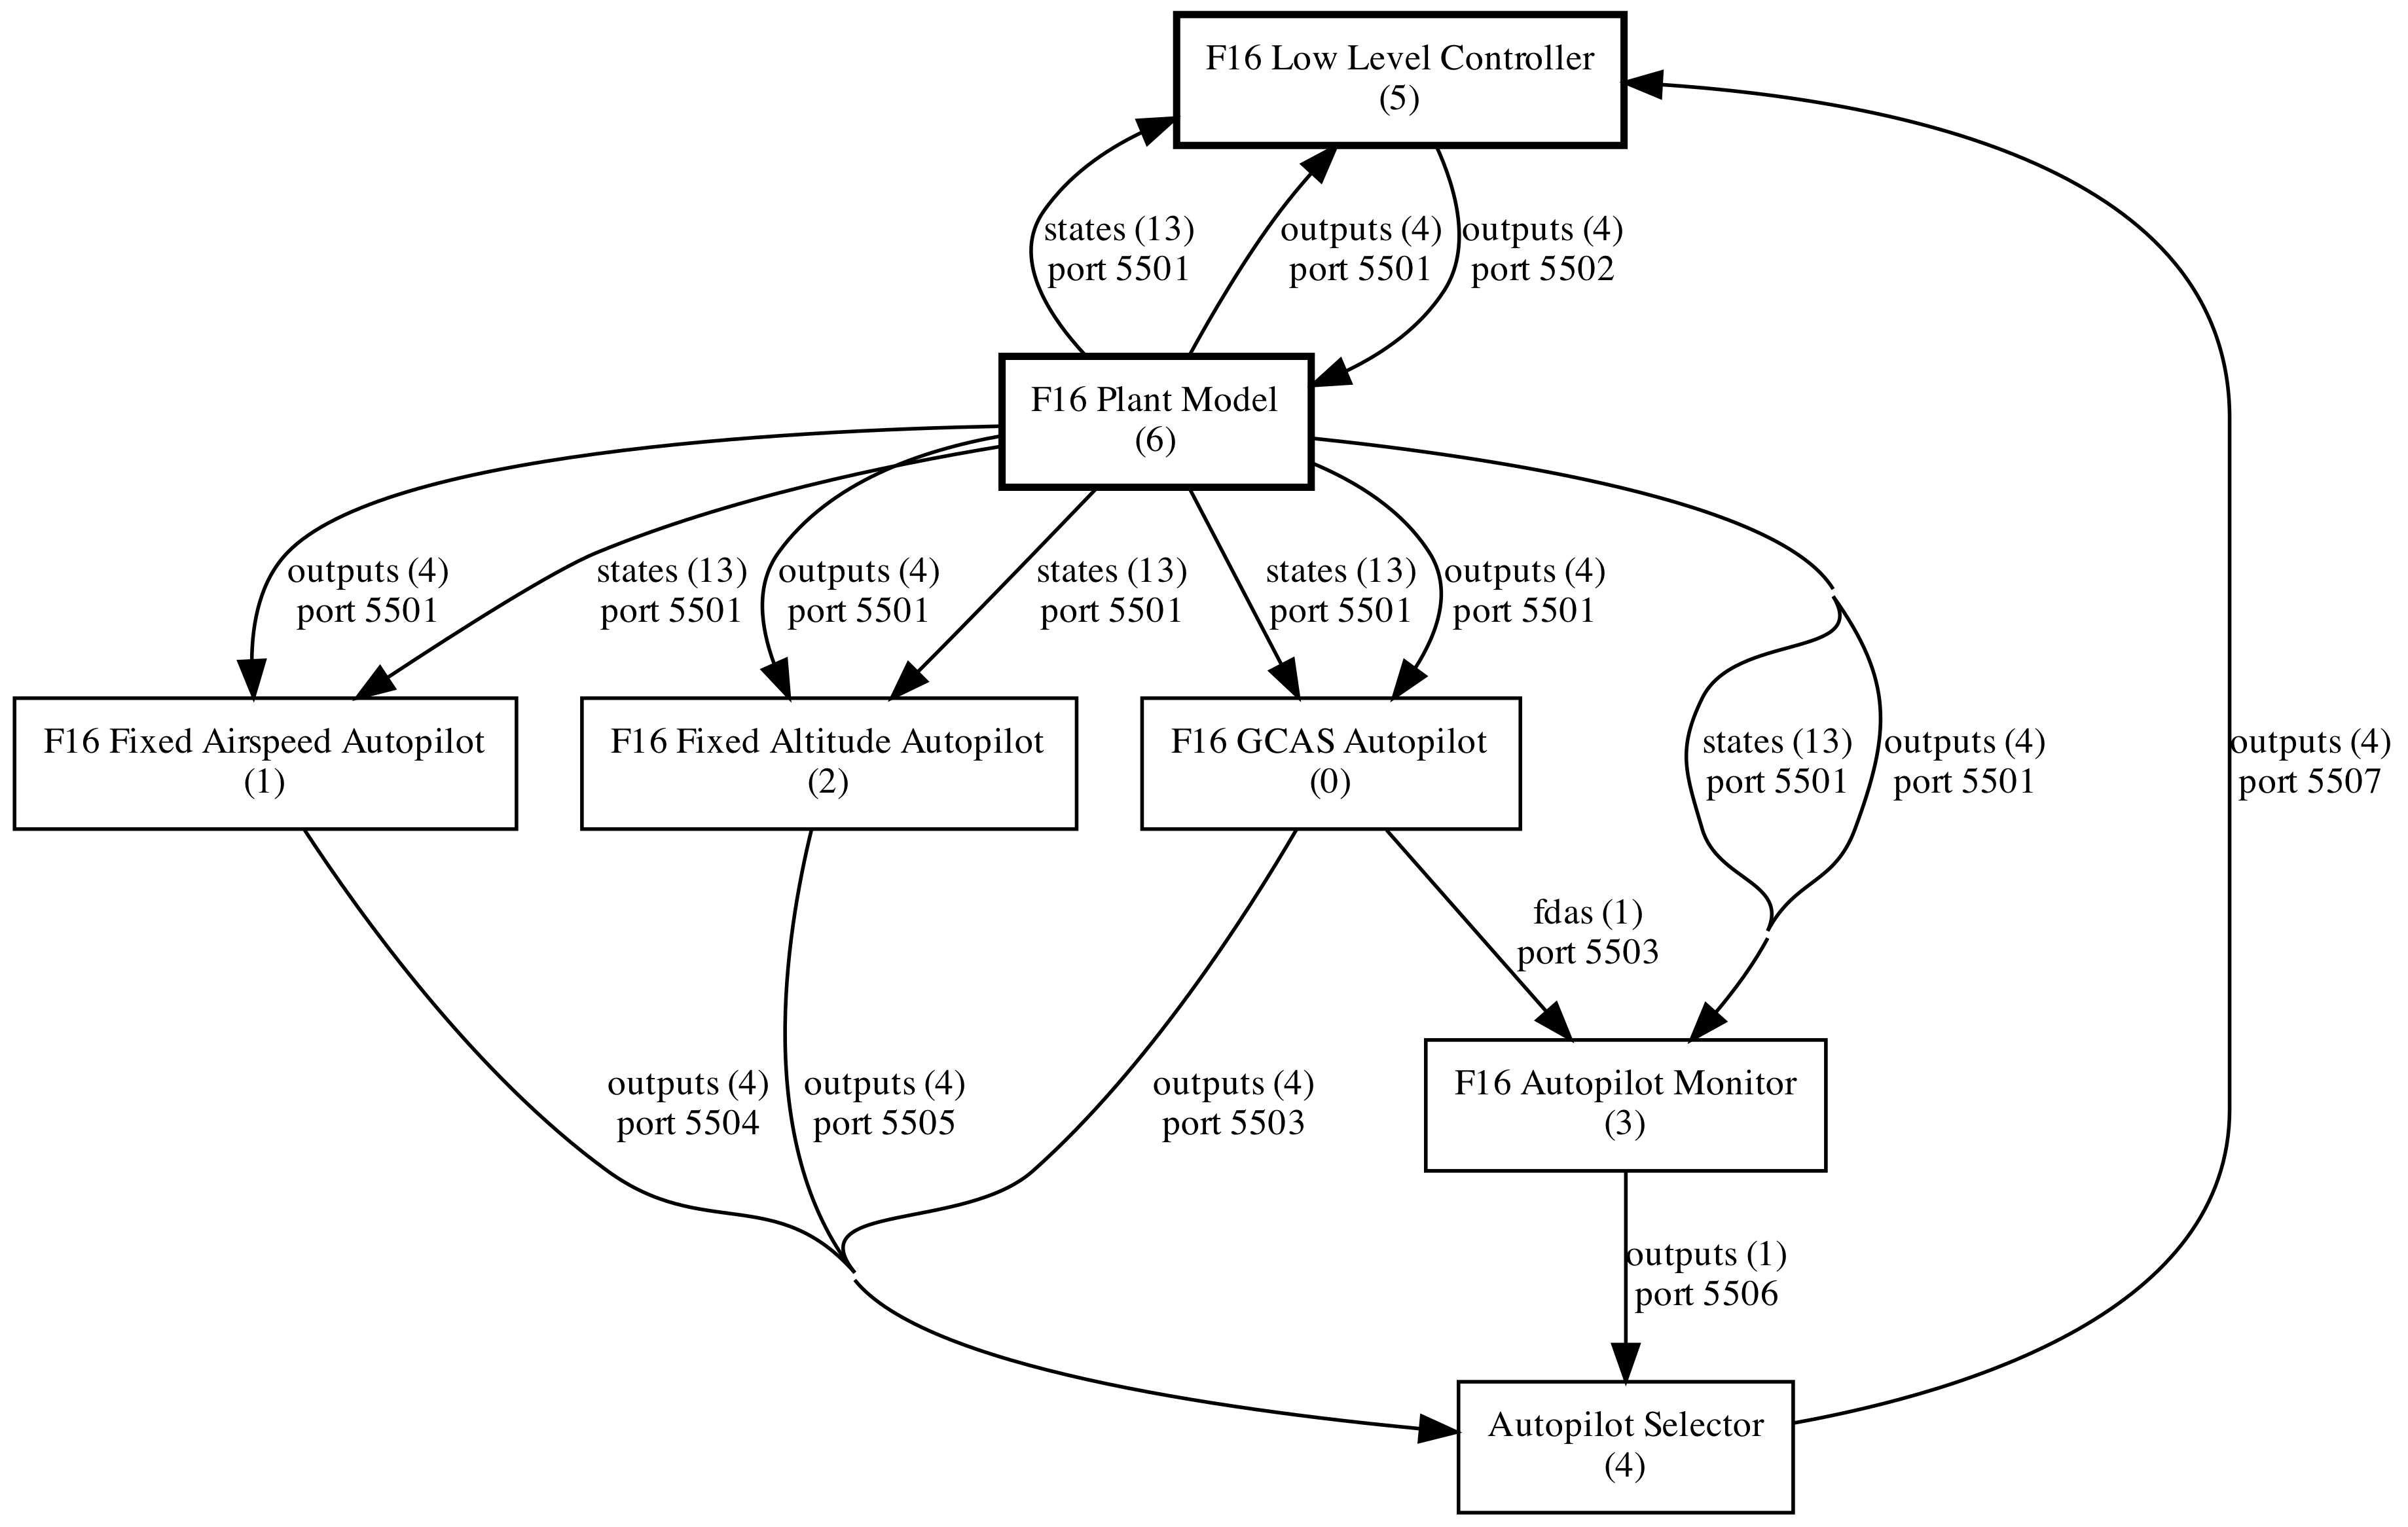

In [3]:
from IPython.display import Image

import pathlib

plot_fname = f"pub-sub-plot.png"

# plot configuration pub/sub diagram as a file -- proj specicies a dot executbale and -Gdpi is a valid dot
# argument to change the image resolution
my_conf.plot_config(fname=pathlib.Path(plot_fname).resolve(), prog=["dot", "-Gdpi=400"])

# display written file to notebook
Image(plot_fname, height=600)

In [4]:
bounds = [(504, 504), 
          (np.deg2rad(2.1215), np.deg2rad(2.1215)), 
          (0.0, 0.0), 
          ((np.pi/2)*0.5, (np.pi/2)*0.5), 
          (-np.pi, np.pi), 
          (-np.pi/4, np.pi/4 ),
         (0.0, 0.0),
         (0.0, 0.0),
         (0.0, 0.0),
         (0.0, 0.0),
         (0.0, 0.0),
         (500, 5000),
         (9, 9)]

run_name = "classical"

rbf_scales = (100, 1, 1, 1, 30, 1, 1, 1, 1, 1, 1, 1000, 1)

n_initial_sampling = 13**2 * 2

In [5]:
x_center = np.array([b[1]/2 + b[0]/2 for b in bounds])
names = my_conf.get_msg_setting("plant", "states", "msg").fields_no_header

In [6]:
def gen_random_state(bounds):
    sample = np.random.rand(len(bounds))
    ranges = np.array([b[1] - b[0] for b in bounds])
    offset = np.array([- b[0] for b in bounds])
    return sample * ranges - offset

def gpr_scalar_field(cx_train, cy_train, x_center, bounds, indices, rbf_scales = rbf_scales):
    x_min, x_max = bounds[indices[0]]
    y_min, y_max = bounds[indices[1]]
    print(x_min, x_max, y_min, y_max)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                             np.linspace(y_min, y_max, 50))

    kernel = 100*RBF(rbf_scales)
    clf = GaussianProcessClassifier(kernel=kernel)
    clf.fit(cx_train, cy_train)

    score = clf.score(cx_train, cy_train)
    dec = np.zeros((len(xx.ravel()), 13))
    for idx in range(0, 13):
        dec[:, idx] = x_center[idx]
    dec[:, indices[0]] = xx.ravel()
    dec[:, indices[1]] = yy.ravel()
    if hasattr(clf, "decision_function"):
            Z = clf.decision_function(dec)
    else:
            Z = clf.predict_proba(dec)[:, 1]
    Z = Z.reshape(xx.shape)
    return xx, yy, Z

def plot_sample_plane(ax, names, xx, yy, zz, x_train=None, y_train=None):
    cm = plt.cm.RdBu
    ax.contourf(xx, yy, zz, cmap=cm, alpha=.8)
    #if x_train is not None and y_train is not None:
    #    ax.scatter(np.rad2deg(x_train[y_train==True, affected_axes[0]]), x_train[y_train==True, affected_axes[1]], marker='o', c='k', s=12)
    #    ax.scatter(np.rad2deg(x_train[y_train==False, affected_axes[0]]), x_train[y_train==False, affected_axes[1]], marker='x', c='k', s=30)
    ax.set_xlabel(f"{names[0]}")
    ax.set_ylabel(f"{names[1]}")
    #ax.scatter(np.rad2deg(xsa_new[ysa_new==True, affected_axes[0]]), xsa_new[ysa_new==True, affected_axes[1]], marker='o', c='k', s=12)
    #ax.scatter(np.rad2deg(xsa_new[ysa_new==False, affected_axes[0]]), xsa_new[ysa_new==False, affected_axes[1]], marker='x', c='k', s=30)
    #ax.set_title('F16 Successful Recovery')
    
def gpr_plot_field(planes, names, bounds, x_all, y_all, x_center):
    n_plots = len(planes)
    n_rows = int(np.floor(n_plots**0.5))
    n_cols =int(np.ceil(n_plots / n_rows))
    fig, ax = plt.subplots(figsize=(n_cols * 5, n_rows * 5), ncols=n_cols, nrows=n_rows)
    for idx, pl in enumerate(planes):
        ridx = idx % n_cols
        cidx = idx // n_cols
        plot_sample_plane(ax[ridx][cidx], (names[pl[0]], names[pl[1]]),  
                          *gpr_scalar_field(x_all, y_all, x_center, bounds, indices=pl))
    plt.tight_layout()    
    return fig, ax

In [7]:
import run_parallel as rp


def term_condition(cname, outs):
        """ground collision"""
        return cname == "plant" and outs["states"][11] <= 0.0
    

def validate_samples(x_samp, config, tspan=(0, 20.0)):
    init_states = [{"plant": xi} for xi in x_samp]
    n = len(init_states)
    ret = rp.run_workgroup(n, config, init_states, tspan, fname="validate_tspan", terminating_conditions=term_condition)
    return tuple(zip(*(x for x in zip(ret, x_samp) if not isinstance(x[0], Exception))))
    
x_init = [gen_random_state(bounds) for _ in range(n_initial_sampling)]

## Uniform Sampling

In [8]:
y_train, x_train = validate_samples(x_init[:100], my_conf)
y_train, x_train = np.array(y_train), np.array(x_train)

100%|██████████| 100/100 [00:00<00:00, 3596.59it/s]


-3.141592653589793 3.141592653589793 500 5000
-3.141592653589793 3.141592653589793 500 5000
-3.141592653589793 3.141592653589793 500 5000
-3.141592653589793 3.141592653589793 500 5000


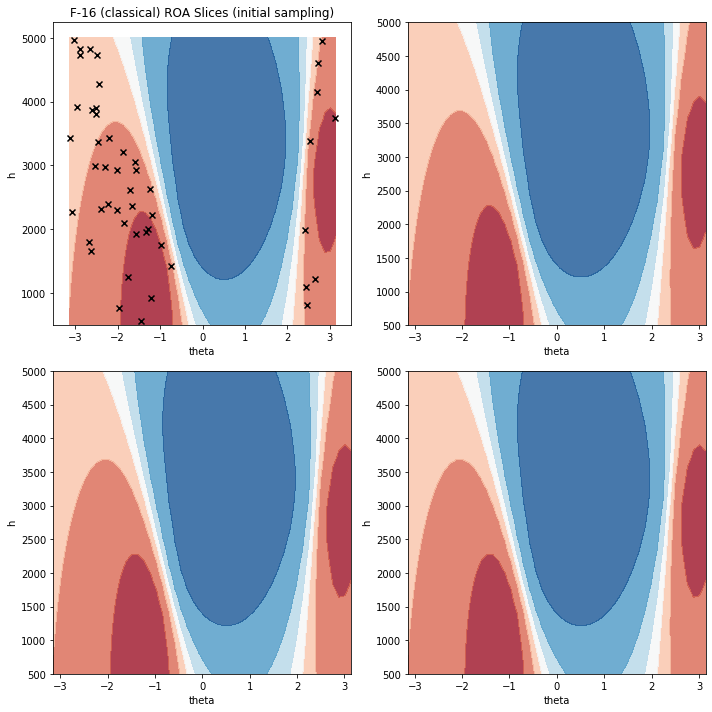

In [12]:
fig, ax = gpr_plot_field([(4, 11), (4, 11), (4, 11), (4, 11)], names, bounds, x_train, y_train, x_center)
ax[0][0].set_title(f"F-16 ({run_name}) ROA Slices (initial sampling)")
ax[0][0].scatter((x_train)[(y_train)==False, 4], (x_train)[(y_train)==False, 11], marker='x', c='k')
#plt.savefig(f"f16_roa_slices_a_priori_{run_name}.pdf")
plt.tight_layout()
plt.show()

## Active Learning Classification

In [32]:
from modAL.uncertainty import entropy_sampling

In [18]:
def GP_regression_std(regressor, X):
    """sampling policy"""
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

# kernel to use for active GP classification
kernel = RBF(rbf_scales)

# active learner
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=x_train, y_training=y_train
)

# define query pool of samples
n_pool_samples = 10000
x_pool = np.array([gen_random_state(bounds) for _ in range(n_pool_samples)])
print(x_train.shape, y_train.shape, x_pool.shape)

In [23]:
xs_new = np.copy(x_train)
ys_new = np.copy(y_train)

for i in tqdm.tqdm(range(5)):
    # query for labels
    x_samp = []
    for i in range(16):
        query_idx, query_inst = learner.query(x_pool)
        x_samp.append(x_pool[query_idx[0]])
        x_pool = np.delete(x_pool, query_idx, axis=1)
        
    # process them in the oracle
    y_train_i, x_train_i = validate_samples(x_samp, my_conf)
    y_train_i, x_train_i = np.array(y_train_i), np.array(x_train_i)
    xs_new = np.vstack((xs_new, x_train_i))
    ys_new = np.hstack((ys_new, y_train_i))
    
    # teach the active learner
    for xi, yi in zip(x_train_i, y_train_i):
        learner.teach(xi[np.newaxis, :], [yi])

  0%|          | 0/5 [00:00<?, ?it/s]/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an err

/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.

 40%|████      | 2/5 [01:16<01:51, 37.25s/it]/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will rai

/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.

 80%|████████  | 4/5 [02:26<00:35, 35.28s/it]/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.
/Users/elew/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will rai

In [26]:
print(xs_new.shape)
print(ys_new.shape)

(180, 13)
(180,)


-3.141592653589793 3.141592653589793 500 5000
-3.141592653589793 3.141592653589793 500 5000
-3.141592653589793 3.141592653589793 500 5000
-3.141592653589793 3.141592653589793 500 5000


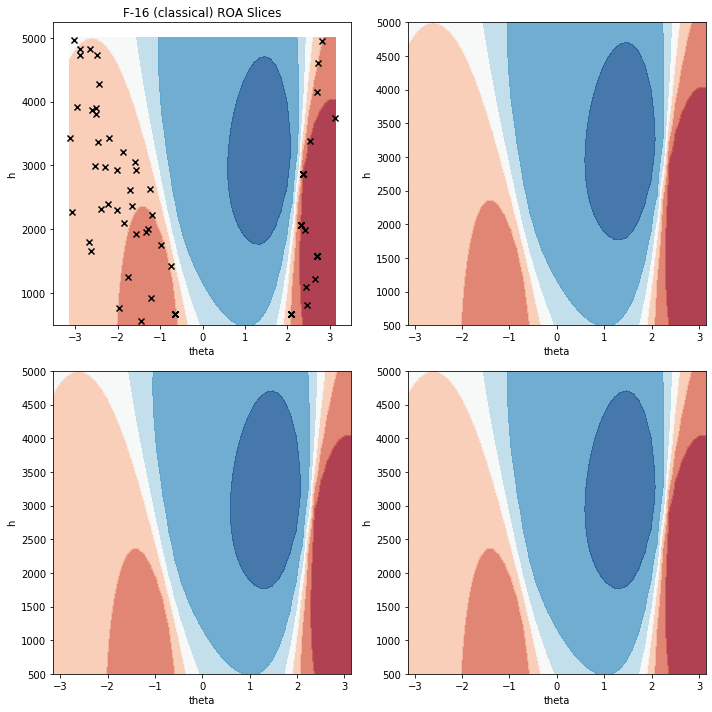

In [31]:
fig, ax = gpr_plot_field([(4, 11), (4, 11), (4, 11), (4, 11)], names, bounds, xs_new[:], ys_new[:], x_center)
ax[0][0].set_title(f"F-16 ({run_name}) ROA Slices")
ax[0][0].scatter((xs_new)[(ys_new)==False, 4], (xs_new)[(ys_new)==False, 11], marker='x', c='k')
#plt.savefig(f"f16_roa_slices_{run_name}.pdf")
plt.tight_layout()
plt.show()